# Feature Preprocessing

In [1]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import sklearn.datasets
from sklearn import metrics
import os
from ray.tune.schedulers import ASHAScheduler
from ray import tune
from ray import train

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# read data and drop unecessary column patient_id
data = pd.read_csv('heart_disease/'+ 'main.csv')
data = data.drop(columns=['patient_id'])

### check the basic data information

In [3]:
# check the basic information of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       644 non-null    int64  
 1   sex       644 non-null    object 
 2   cp        644 non-null    object 
 3   trestbps  606 non-null    float64
 4   chol      622 non-null    float64
 5   fbs       573 non-null    object 
 6   restecg   643 non-null    object 
 7   thalch    608 non-null    float64
 8   exang     608 non-null    object 
 9   oldpeak   606 non-null    float64
 10  slope     444 non-null    object 
 11  ca        221 non-null    float64
 12  thal      307 non-null    object 
 13  num       644 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 70.6+ KB


In [4]:
# find out the object features
object_data = data.select_dtypes(include=['object']).columns.to_list()
print(f"Number of object data: {len(object_data)}.")
print(f"They are: {object_data}\n")

# find out the numeric features
numeric_data = data.select_dtypes(include=['int', 
                                           'float']).columns.to_list()
numeric_data = [data for data in numeric_data if data != 'num']
print(f'Number of numeric data: {len(numeric_data)}.')
print(f'They are: {numeric_data}\n')

# check out the ratios of null values in each feature 
null_ratio = data.isnull().sum()/len(data)
print('The ration of null in each column is:')
print(null_ratio.sort_values(ascending=False))

Number of object data: 7.
They are: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

Number of numeric data: 6.
They are: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

The ration of null in each column is:
ca          0.656832
thal        0.523292
slope       0.310559
fbs         0.110248
trestbps    0.059006
oldpeak     0.059006
thalch      0.055901
exang       0.055901
chol        0.034161
restecg     0.001553
age         0.000000
sex         0.000000
cp          0.000000
num         0.000000
dtype: float64


In [5]:
# check how many categories are there in each feature
for col in object_data:
    num = len(data[col].unique())
    print(f'Number of categories in feature "{col}" is: {num}')

Number of categories in feature "sex" is: 2
Number of categories in feature "cp" is: 4
Number of categories in feature "fbs" is: 3
Number of categories in feature "restecg" is: 4
Number of categories in feature "exang" is: 3
Number of categories in feature "slope" is: 4
Number of categories in feature "thal" is: 4


### Use random forest to fill null values

In [6]:
bool_cols = ['fbs', 'exang']

In [7]:
# Use random forest to fill the null values (for category features)
def rf_category(missing_col, data):

    data_copy = data.copy()

    # fill 0 those null value in numeric feature
    data[numeric_data] = data[numeric_data].fillna(0,inplace=False)
    
    # one-hot encode to catergory feature
    data_encoded = pd.get_dummies(data.drop(columns=[missing_col]))
    data_encoded[missing_col] = data[missing_col]

    # split train and test dataset
    null_rows = data_encoded[data_encoded[missing_col].isnull()] 
    not_null_rows = data_encoded[~data_encoded[missing_col].isnull()] 
    
    X_train = not_null_rows.drop(columns=[missing_col])
    y_train = not_null_rows[missing_col]

    X_test = null_rows.drop(columns=[missing_col])

    # Handling Boolean type data
    label_encoder = LabelEncoder()
    if missing_col in bool_cols:
        y_train = label_encoder.fit_transform(y_train)

    # train a random forest to fill in null value
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train, y_train)

    # concat the train dataset and test dataset
    data_copy.loc[X_test.index,missing_col]=rf_classifier.predict(X_test)
    
    return data_copy

In [8]:
# Use random forest to fill the null values (for numeric features)
def rf_numeric(missing_col, data):
    
    data_copy = data.copy()

    # # fill 0 those null value in numeric feature
    data_tmp = data.copy()
    data_tmp[numeric_data]=data_tmp[numeric_data].fillna(0,inplace=False)
    data_tmp[missing_col] = data[missing_col]

    # one-hot encode to catergory feature
    data_encoded = pd.get_dummies(data_tmp)

    # split train and test dataset
    null_rows = data_encoded[data_encoded[missing_col].isnull()] 
    not_null_rows = data_encoded[~data_encoded[missing_col].isnull()] 

    X_train = not_null_rows.drop(columns=[missing_col])
    y_train = not_null_rows[missing_col]

    X_test = null_rows.drop(columns=[missing_col])

    # train a random forest to fill in null value
    rf_classifier = RandomForestRegressor()
    rf_classifier.fit(X_train, y_train)
    null_rows[missing_col] = rf_classifier.predict(X_test)

    # concat the train dataset and test dataset
    data_copy.loc[X_test.index,missing_col]=rf_classifier.predict(X_test)

    return data_copy

In [9]:
def rf_missing_value(null_feature, data):

    for feature in null_feature:

        # if feature is numeric, then excute rf_numeric
        if data[feature].dtypes in ['float64', 'int64'] :
            data = rf_numeric(feature, data)
        
        # if feature is object, then excute rf_category
        if data[feature].dtypes in ['object'] :
            data = rf_category(feature, data)
    
    return data

In [10]:
# find out the features that have null values
# then sort them in decending order
null_ratio = data.isnull().sum()
sort_null_ratio = null_ratio.sort_values()
null_feature = sort_null_ratio[null_ratio > 0].index.tolist()

In [11]:
# deal with the missing values
data = rf_missing_value(null_feature, data)

# check again if there are null values now
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       644 non-null    int64  
 1   sex       644 non-null    object 
 2   cp        644 non-null    object 
 3   trestbps  644 non-null    float64
 4   chol      644 non-null    float64
 5   fbs       644 non-null    object 
 6   restecg   644 non-null    object 
 7   thalch    644 non-null    float64
 8   exang     644 non-null    object 
 9   oldpeak   644 non-null    float64
 10  slope     644 non-null    object 
 11  ca        644 non-null    float64
 12  thal      644 non-null    object 
 13  num       644 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 70.6+ KB


### Use one-hot to encode categorial data

In [12]:
data_encoded = pd.get_dummies(data)

### Dividing the dataset into training, validation,and test sets

In [13]:
feature = data_encoded.drop(columns=['num'])
label = data_encoded['num']

X_trainval, X_test, y_trainval, y_test = train_test_split(feature,
                             label, test_size=0.3,random_state=25)

# Training Classifiers

In [14]:
# customize a function for calculating accuracy
def acc(gt, pred):
    f1 = f1_score(gt, pred, average='macro')
    accuracy = accuracy_score(gt, pred)
    return 0.5 * (f1 + accuracy)

custom_scorer = make_scorer(acc, greater_is_better=True)

### Use logistic regression with grid search method

In [15]:
# train a logistic regression model
model = LogisticRegression()

# define the parameters for grid searching
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  
}

lr = LogisticRegression()
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(X_trainval, y_trainval)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.4630678533679144


In [16]:
# use the model on test dataset
test_score = grid_search.score(X_test,y_test)
print(f'The score for test dataset is: ', test_score)

The score for test dataset is:  0.455107318503957


### Use random forest with ray[tune] method

In [17]:
X_train, X_tmp, y_train, y_tmp = train_test_split(feature, 
                    label, test_size=0.3, random_state=25)

X_val, X_test, y_val, y_test = train_test_split(X_tmp, 
                y_tmp, test_size=0.33, random_state=25)

In [18]:
def train_rf(config: dict, data=None):
    
    # Initialize the RandomForestClassifier with the configuration
    classifier = RandomForestClassifier(
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        min_samples_split=config["min_samples_split"],
        min_samples_leaf=config["min_samples_leaf"],
        class_weight="balanced",
        random_state=42
    )
    
    # Fit the RandomForestClassifier on the training data
    X_train = data[0]
    y_train = data[1]
    X_validation = data[2]
    y_validation = data[3]

    # To Be filled: Train your Random Forest Classifier here
    classifier.fit(X_train, y_train)
    
    # To Be filled: Evaluate the classifier on the validation 
    # set here and get evaluation accuracy 
    prediction = classifier.predict(X_validation)
    acc1 = acc(y_validation, prediction)
    
    # Send the accuracy to Ray Tune
    train.report({'accuracy': acc1})

# note that X_train, y_train, X_validation, y_validation 
# are your training and validation data.
tunable_function = tune.with_parameters(train_rf, 
                data=[X_train, y_train, X_val, y_val])

def tune_random_forest(smoke_test=False):
    # Define the search space for hyperparameters
    search_space = {
        "n_estimators": tune.choice([10, 50, 100, 200]),
        "max_depth": tune.choice([5, 10, 15, 20]),
        "min_samples_split": tune.choice([2, 5, 10]),
        "min_samples_leaf": tune.choice([1, 2, 4, 6]) 
    }
    
    # Define the scheduler for early stopping
    scheduler = ASHAScheduler(
        max_t= 100, 
        grace_period= 10, 
        reduction_factor= 2
    )
    
    # Set up the tuner
    tuner = tune.Tuner(
        tunable_function,
        tune_config=tune.TuneConfig(
            metric="accuracy",
            mode="max",
            scheduler=scheduler,
            num_samples=1 if smoke_test else 200,
        ),
        param_space=search_space,
    )
    
    # Execute the tuning process
    results = tuner.fit()
    
    return results

# Run the tuning function
best_results = tune_random_forest(smoke_test=False)
best_trial = best_results.get_best_result(metric="accuracy", mode="max")

# Get the best trial's hyperparameters
best_params = best_trial.config

# Print the best hyperparameters
print("Best hyperparameters found were: ", best_params)

# Initialize a new RandomForestClassifier with the best hyperparameters
best_rf = RandomForestClassifier(**best_params, random_state=42)

2024-03-16 16:09:13,977	INFO tune.py:1042 -- Total run time: 10.85 seconds (8.81 seconds for the tuning loop).


Best hyperparameters found were:  {'n_estimators': 10, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [19]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

# evaluate the accuracy on test dataset
print("Accuracy:", acc(y_test, y_pred))

Accuracy: 0.5584740334740335


# Additional Tweaking and External Test Set Benchmark

### Utilizing different classifiers, XGBoost with cross validation (cv=5)

In [20]:
# Intialize the XGBoost
xgb_clf = xgb.XGBClassifier(reg_alpha=0.8)

# define the parameters for grid search
param_grid = {
    'n_estimators': [4, 6 ,8 ,10],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [4, 6, 8, 10]
}

# customize the function for evaluation
custom_scorer = make_scorer(acc, greater_is_better=True)

# tune parameters based on cross validation (k=5)
grid_search = GridSearchCV(estimator=xgb_clf, 
                           param_grid=param_grid, 
                           scoring=custom_scorer, cv=5)
grid_search.fit(X_trainval, y_trainval)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# evaluate the accuracy on test dataset
y_pred = grid_search.predict(X_test)

print("Test set accuracy: ", acc(y_pred, y_test))

Best parameters: {'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 10}
Best score: 0.5255811044714565
Test set accuracy:  0.5631701631701632


##### Generally speaking, XGBoost has better predictive performance than random forests, because it focuses more on misclassified samples by reducing the residuals of the previous predictions. Meanwhile, XGBoost effectively controls the problem of model overfitting through regularization, such as setting alpha to 0.8 in my code. In this code, grid search is used to search for the best parameters of XGBoost and added cross validation, setting the cv to 5 to prevent randomness in the prediction results.

##### When I switched the model from random forest to XGBoost, the accuracy of the model increased from 55.8% to 56.3%.

### Addressing issues of class imbalance (with classifier XGBoost)

In [21]:
# Check the quantity of each category 
# and find that the categories are extremely imbalanced
y_trainval.value_counts()

0    195
1    128
2     55
3     53
4     19
Name: num, dtype: int64

In [22]:
# Using SMOTE method to increase the number of minority categories
smo = SMOTE(sampling_strategy={1: 150, 2: 120, 3:100, 4:100})
X_sampling, y_sampling = smo.fit_resample(X_trainval, y_trainval)

print("After SMOTE -- The distribution of each class: ")
print(y_sampling.value_counts())

After SMOTE -- The distribution of each class: 
0    195
1    150
2    120
3    100
4    100
Name: num, dtype: int64


In [23]:
# Intialize the XGBoost
xgb_clf_balance = xgb.XGBClassifier(reg_alpha=0.8)

# tune parameters based on cross validation (k=5)
grid_search_balance = GridSearchCV(estimator=xgb_clf_balance, 
                                   param_grid=param_grid, 
                                   scoring=custom_scorer, cv=5)
grid_search_balance.fit(X_sampling, y_sampling)

print("Best parameters:", grid_search_balance.best_params_)
print("Best score:", grid_search_balance.best_score_)

# evaluate the accuracy on test dataset
y_pred = grid_search_balance.predict(X_test)

print("Test set accuracy: ", acc(y_pred, y_test))

Best parameters: {'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 10}
Best score: 0.6925576227191002
Test set accuracy:  0.6207948717948718


##### If we print out the number of each category, we can see that this dataset is highly imbalanced. Class 0 has a maximum of 195 data (43.3% of train dataset), but the minimum of 4 categories has only 19 data (4.2% of train dataset), the imbalance ratio reaches 10:1. Unbalanced data can lead to a trained model with good training results for categories with large samples but poor training results for categories with few samples, as the model cannot learn features from minority categories.

##### There are usually two ways to handle data imbalance, which are upsampling and downsampling. Due to the small sample size of this dataset, downsampling the majority category may result in the model not being able to fully learn the features of the majority category. Therefore, the SMOTE method is used to upsample the minority category. It can be observed from the result that the evaluation (0.5 * f1 + 0.5 * accuracy) of the model on the test dataset increased by 6.4% compared to using only XGBoost.

### Write the test data into a csv

In [ ]:
# prepare the test dataset of external_test.csv with preproccessing
test_data = pd.read_csv("heart_disease/'+ 'test.csv")
test_data = rf_missing_value(null_feature, test_data)
test_data_encoded = pd.get_dummies(test_data)

# train the XGBoost model based on best parameters
best_config = grid_search_balance.best_params_

best_xgb_clf = xgb.XGBClassifier(**best_config, reg_alpha=1.0)
best_xgb_clf.fit(feature, label)

# output the predicted labels
test_feature = test_data_encoded.drop(columns=['patient_id'])
patient_id = test_data_encoded['patient_id']

test_pred = best_xgb_clf.predict(test_feature)

In [25]:
# store patient_id and predicted labels in to a dataframe
results_df = pd.DataFrame({
    'patient_id': patient_id,
    'prediction': test_pred
})

In [ ]:
# store the dataframe into a csv
results_df.to_csv('test_result.csv', index=False)

# Result Analysis

### Compute critical performance matrix and confusion matrix (XGBoost)

In [27]:
# define a general evaluation for accuracy, f1_score, precision and recall
def evaluation(label, predict):

    accuracy = accuracy_score(label, predict)
    f1 = f1_score(label, predict, average='macro' )
    precision = precision_score(label, predict, average='macro')
    recall = recall_score(label, predict, average='macro')

    print(f'XGBoost\n')
    print('accuracy is: ', accuracy)
    print('f1 score is: ', f1)
    print('precision is: ', precision)
    print('recall is: ', recall)

evaluation(y_test, y_pred)

XGBoost

accuracy is:  0.7538461538461538
f1 score is:  0.4877435897435897
precision is:  0.6461904761904761
recall is:  0.4621428571428572


In [28]:
# define a evaluation for each class
def evaluation_each_class(label, predict):

    f1_each_class = f1_score(label, predict, average=None)
    precision_each_class = precision_score(label, predict, average=None)
    recall_each_class = recall_score(label, predict, average=None)

    for i in range(5):
        print(f'\nFor class {i}')
        print('f1 score is: ', f1_each_class[i])
        print('precision is: ', precision_each_class[i])
        print('recall is: ', recall_each_class[i])

evaluation_each_class(y_test, y_pred)


For class 0
f1 score is:  0.9066666666666667
precision is:  0.85
recall is:  0.9714285714285714

For class 1
f1 score is:  0.6666666666666666
precision is:  0.7142857142857143
recall is:  0.625

For class 2
f1 score is:  0.25
precision is:  1.0
recall is:  0.14285714285714285

For class 3
f1 score is:  0.6153846153846153
precision is:  0.6666666666666666
recall is:  0.5714285714285714

For class 4
f1 score is:  0.0
precision is:  0.0
recall is:  0.0


##### In the previous code, the number of samples for minority categories (classes 1-4) was increased through SMOTE technique, but the performance on class 4 was still not good. Perhaps it is because there is still a significant deviation between the artificially synthesized data and the actual data, so the model has not yet learned the features of class 4 well. If possible, it is necessary to further increase the accuracy of class 4 by adding real data.

In [29]:
# define a function to plot the confusion matrix
def plot_confusion_matrix(cm, labels_name, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)  

    # print the labels in each subsquare  
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.annotate(cm[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')


    num_local = np.array(range(len(labels_name)))    
    
    plt.xticks(num_local, labels_name)    
    plt.yticks(num_local, labels_name)    
    plt.title(title)    
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')


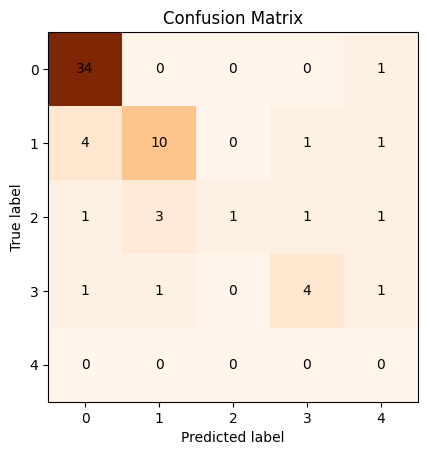

In [30]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mat, [0,1,2,3,4], "Confusion Matrix")

### Feature importance plot (XGBoost)

<Axes: >

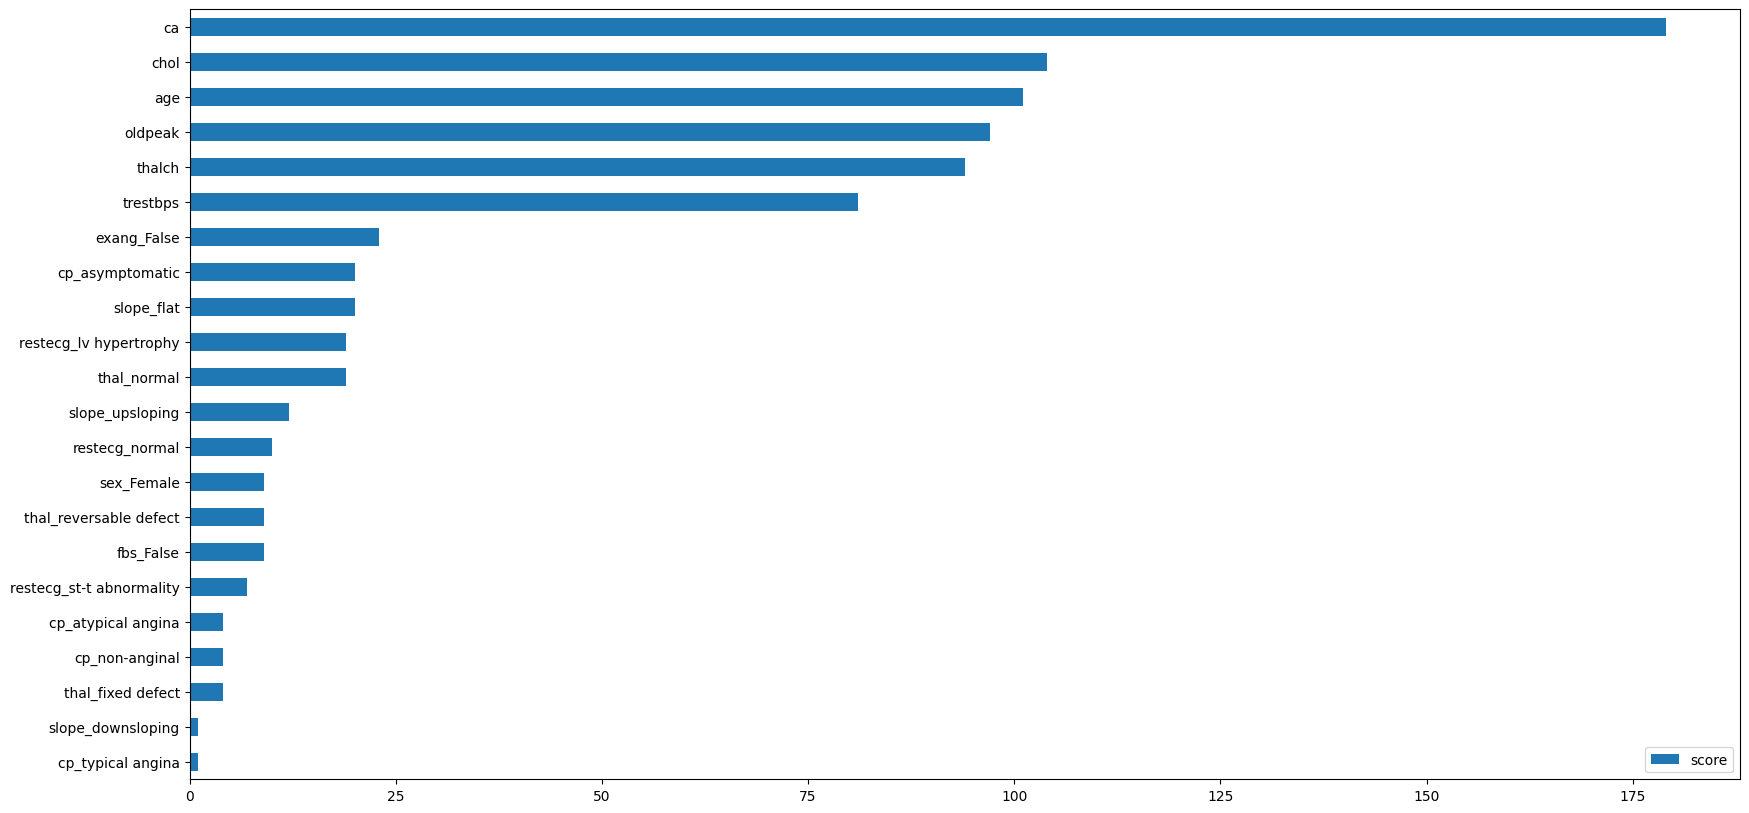

In [31]:
# find out the feature importance with best model xgboost
importance = best_xgb_clf.get_booster().get_score(importance_type='weight')
keys = list(importance.keys())
values = list(importance.values())

# plot the feature importance of XGBoost
data = pd.DataFrame(data=values, index=keys, 
                    columns=["score"]).sort_values(by = "score")
data.plot(kind='barh', figsize = (20,10))

##### It could be observed from the plot that the most important 3 features are ca, thalch, oldpeak